## 1. Mengimpor library yang dibutuhkan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
from nltk.corpus import wordnet
from googletrans import Translator
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


## 2. Load Data
Memuat dataset dari file CSV dan menampilkan informasi dasar tentang data seperti tipe data dan jumlah nilai yang hilang.

In [2]:
# Load data
df = pd.read_csv("liputan6.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10972 entries, 0 to 10971
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_article  10972 non-null  object
 1   clean_summary  10972 non-null  object
dtypes: object(2)
memory usage: 257.2+ KB


Menampilkan statistik deskriptif untuk kolom bertipe objek.

In [3]:
df.describe(include='O')

,clean_article,clean_summary
count,10972,10972
unique,10961,10958
top,"Liputan6. com, Jakarta : Di masyarakat, televi...",Sebuah tenda didirikan dekat pintu keluar jala...
freq,4,2


Menampilkan 5 baris pertama dari dataset untuk melihat data.

In [4]:
df.head()

,clean_article,clean_summary
0,"Liputan6. com, Surabaya : Radiogram Direktorat...",Gubernur Jatim Imam Utomo tak mau melantik Bup...
1,"Liputan6. com, Jakarta : Berbeda dengan aliran...",Pelukis RM Koestarto memamerkan hasil karyanya...
2,"Liputan6. com, Jambi : Ratusan orang dari Kesa...","Dua kelompok pengunjuk rasa di Jambi, menuntut..."
3,"Liputan6. com, Jakarta : Badan Penyehatan Perb...",BPPN masih mengkaji bank rekap yang dianggap p...
4,"Liputan6. com, Jakarta : Ketua Komisi I DPR Ya...",Kendati Dewan Papua membatalkan deklarasi keme...


## 2. Selecting Necessary Columns and Dropping NaN Values
Memilih kolom yang relevan ('clean_article' dan 'clean_summary') dan menghapus data yang hilang (NaN).

In [5]:
# Selecting necessary columns and dropping NaN values
data = df[['clean_article', 'clean_summary']].dropna()

In [6]:
# Menampilkan jumlah total data dalam dataset
print("Total data dalam dataset:", len(df))

# Menampilkan jumlah data yang ada di setiap kolom 'clean_article' dan 'clean_summary'
print("Total data di kolom 'clean_article':", df['clean_article'].notnull().sum())
print("Total data di kolom 'clean_summary':", df['clean_summary'].notnull().sum())

# Menjumlahkan total data non-null dari kedua kolom
total_non_null = df['clean_article'].notnull().sum() + df['clean_summary'].notnull().sum()
print("Total dari kedua kolom (clean_article dan clean_summary):", total_non_null)

Total data dalam dataset: 10972
Total data di kolom 'clean_article': 10972
Total data di kolom 'clean_summary': 10972
Total dari kedua kolom (clean_article dan clean_summary): 21944


## 3. Selecting Subset Data and view it
Mengambil 10% data dari data asli untuk digunakan

In [7]:
# Mengambil subset data
df = df.sample(frac=0.10, random_state=50)  # Menggunakan 10% dari dataset

Menampilkan jumlah data terkini

In [8]:
# Menampilkan jumlah total data dalam dataset
print("Total data dalam dataset:", len(df))

# Menampilkan jumlah data yang ada di setiap kolom 'clean_article' dan 'clean_summary'
print("Total data di kolom 'clean_article':", df['clean_article'].notnull().sum())
print("Total data di kolom 'clean_summary':", df['clean_summary'].notnull().sum())

# Menjumlahkan total data non-null dari kedua kolom
total_non_null = df['clean_article'].notnull().sum() + df['clean_summary'].notnull().sum()
print("Total dari kedua kolom (clean_article dan clean_summary):", total_non_null)

Total data dalam dataset: 1097
Total data di kolom 'clean_article': 1097
Total data di kolom 'clean_summary': 1097
Total dari kedua kolom (clean_article dan clean_summary): 2194


## 3. Visualizing Sentiment Distribution and WordCloud
Menggambarkan distribusi sentimen dalam data menggunakan grafik batang.

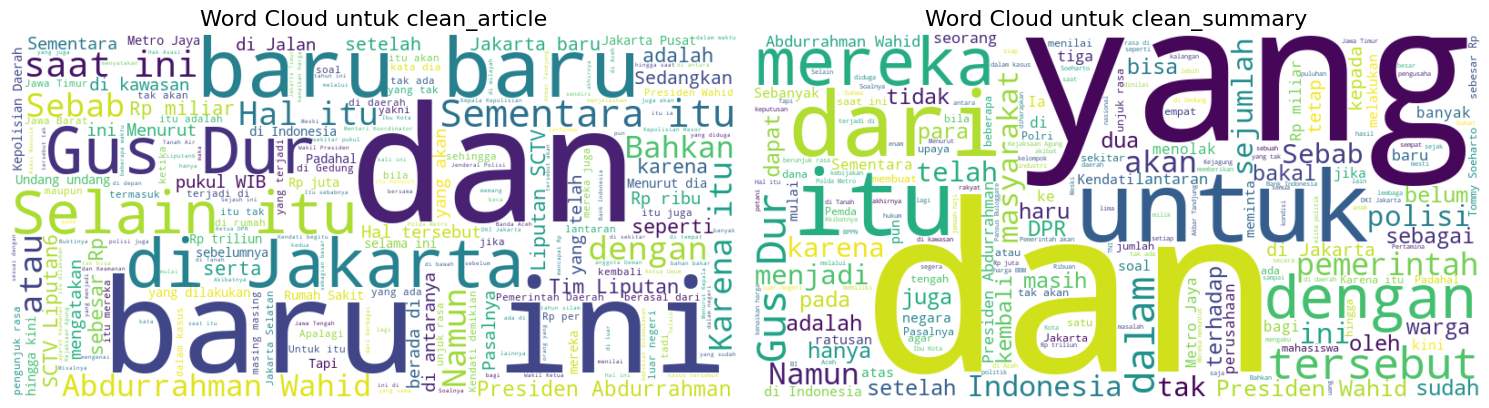

In [ ]:
# Menghitung jumlah kata rata-rata untuk clean_article dan clean_summary
df['article_word_count'] = df['clean_article'].apply(lambda x: len(x.split()))
df['summary_word_count'] = df['clean_summary'].apply(lambda x: len(x.split()))

# Menghitung rata-rata jumlah kata
avg_word_count = {
    'clean_article': df['article_word_count'].mean(),
    'clean_summary': df['summary_word_count'].mean()
}

# Membuat word cloud untuk clean_article
wordcloud_article = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['clean_article']))

# Membuat word cloud untuk clean_summary
wordcloud_summary = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['clean_summary']))

# Menampilkan word cloud
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_article, interpolation='bilinear')
plt.title('Word Cloud untuk clean_article', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.title('Word Cloud untuk clean_summary', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Tokenization, Padding, and Vocab Size

Tokenisasi teks untuk mengonversinya menjadi urutan angka berdasarkan frekuensi kata dalam data pelatihan.

In [10]:
# Menggunakan Tokenizer untuk teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_article'].tolist() + df['clean_summary'].tolist())

# Konversi teks menjadi sequences
input_sequences = tokenizer.texts_to_sequences(df['clean_article'].tolist())
target_sequences = tokenizer.texts_to_sequences(df['clean_summary'].tolist())

# Padding sequences untuk memastikan panjangnya seragam
max_input_len = 500  # Batasi panjang maksimum input sequence
max_target_len = 50  # Batasi panjang maksimum target sequence

input_sequences = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_target_len, padding='post')

# Mendapatkan ukuran vocabulary
vocab_size = len(tokenizer.word_index) + 1

## 5. Augmentasi Data
Fungsi untuk augmentasi teks dengan mengganti beberapa kata dengan berbagai metode berikut

In [11]:
# Fungsi untuk augmentasi teks dengan mengganti kata dengan sinonim
def synonym_replacement(text):
    words = text.split()    # Memisahkan teks menjadi kata-kata
    new_words = words.copy()    # Menyalin kata-kata
    word_idx = random.randint(0, len(words)-1)  # Pilih indeks acak
    word = words[word_idx]
    
    # Mendapatkan sinonim
    synonyms = wordnet.synsets(word)
    if synonyms:
        synonym = random.choice(synonyms).lemmas()[0].name()
        new_words[word_idx] = synonym if synonym != word else word  # Pastikan tidak mengganti dengan kata yang sama
    
    return ' '.join(new_words)

# Fungsi back translation (terjemahkan ke bahasa Inggris, kemudian kembali ke bahasa Indonesia)
def back_translation(text, src='id', dest='en'):
    translator = Translator()
    translated = translator.translate(text, src=src, dest=dest).text
    back_translated = translator.translate(translated, src=dest, dest=src).text
    return back_translated

# Fungsi untuk augmentasi dataset
def augment_dataset(df):
    augmented_articles = []
    augmented_summaries = []
    
    for i in range(len(df)):
        article = df.iloc[i]['clean_article']
        summary = df.iloc[i]['clean_summary']
        
        # Menerapkan augmentasi
        augmented_articles.append(synonym_replacement(article))
        augmented_summaries.append(synonym_replacement(summary))
    
    augmented_df = pd.DataFrame({
        'clean_article': augmented_articles,
        'clean_summary': augmented_summaries
    })
    
    return augmented_df

## 6. Membagi Dataset
Membagi data menjadi fitur (X) dan label (y), kemudian membagi data menjadi data pelatihan dan data pengujian.

In [12]:
# Model dengan validasi
X_train, X_temp, y_train, y_temp = train_test_split(input_sequences, target_sequences, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Padding target sequences untuk validasi dan testing
y_train = pad_sequences(y_train, maxlen=max_input_len, padding='post')
y_val = pad_sequences(y_val, maxlen=max_input_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_input_len, padding='post')

# Menampilkan ukuran dataset
print(f"Training data: {len(X_train)}")
print(f"Validation data: {len(X_val)}")
print(f"Testing data: {len(X_test)}")

Training data: 767
Validation data: 165
Testing data: 165


## 7. Model LSTM
Menggunakan LSTM untuk memprediksi model beserta beberapa layer lainnya.

In [13]:
# Model LSTM
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_input_len))  # Dimensi embedding lebih besar
model.add(LSTM(128, return_sequences=True))  # LSTM dengan lebih banyak unit
model.add(Dropout(0.4))  # Dropout lebih tinggi untuk mengurangi overfitting
model.add(Dense(vocab_size, activation='softmax'))  # Output layer yang lebih padat
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Gunakan Adam optimizer

# Memastikan model dibangun dengan benar sebelum melihat summary
model.build(input_shape=(None, max_input_len))  # Memaksa model untuk dibangun dengan input shape yang benar
model.summary()  # Menampilkan summary model

e:\Software\Python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 128)       │     1,972,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 500, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500, 15411)     │     1,988,019 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,092,211 (15.61 MB)

 Trainable params: 4,092,211 (15.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Callbacks untuk training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Melatih model
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=160,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 126s 26s/step - accuracy: 0.4985 - loss: 9.5193 - val_accuracy: 0.9555 - val_loss: 8.9881 - learning_rate: 0.0010
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 187s 34s/step - accuracy: 0.9556 - loss: 8.7737 - val_accuracy: 0.9555 - val_loss: 7.6759 - learning_rate: 0.0010
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 141s 28s/step - accuracy: 0.9557 - loss: 7.3300 - val_accuracy: 0.9555 - val_loss: 6.1608 - learning_rate: 0.0010
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 65s 13s/step - accuracy: 0.9555 - loss: 5.8500 - val_accuracy: 0.9555 - val_loss: 4.7031 - learning_rate: 0.0010
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 64s 13s/step - accuracy: 0.9555 - loss: 4.3875 - val_accuracy: 0.9555 - val_loss: 3.2782 - learning_rate: 0.0010
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 69s 14s/step - accuracy: 0.9557 - loss: 2.9959 - val_accuracy: 0.9555 - val_loss: 2.0049 - learning_rate: 0.0010
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 78s 16s/step - accuracy: 0.9554 - loss: 1.8112 - val_accuracy: 0.95

## 8. Plot Training History
Untuk memvisualisasikan memplot akurasi dan loss selama pelatihan.

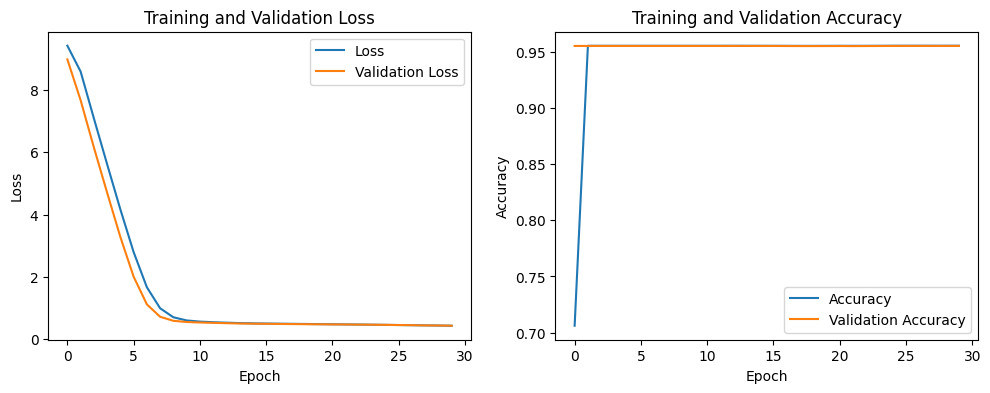

In [15]:
# Plotting Loss dan Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 9. Percobaan Implementasi Meringkas Teks

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 659ms/step
Shape y_test_true: (165,), y_test_pred: (165,)
Test Accuracy: 0.0242

Test Classification Report:
               precision    recall  f1-score   support

           0       0.02      1.00      0.05         4
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00        

e:\Software\Python\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Software\Python\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Software\Python\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


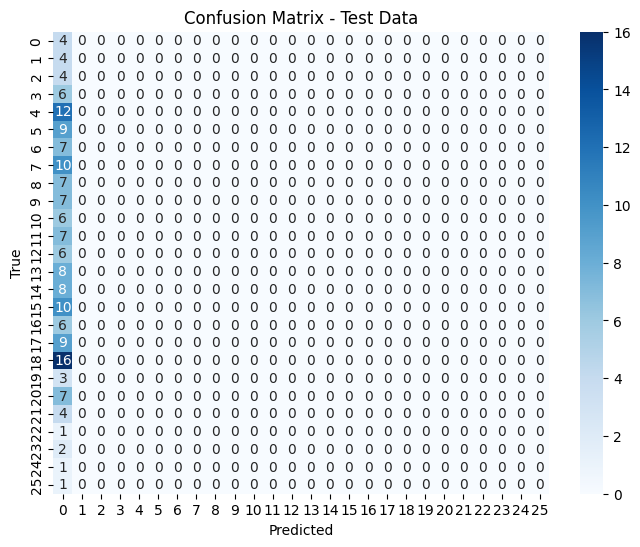

In [16]:
# Evaluasi pada data test
chunk_size = 1000  # Sesuaikan ukuran chunk untuk mencegah penggunaan memori yang berlebihan
y_test_pred = []

# Prediksi data dalam batch kecil
for i in range(0, len(X_test), chunk_size):
    batch_X = X_test[i:i+chunk_size]
    batch_pred_prob = model.predict(batch_X, batch_size=32)  # batch_size lebih kecil
    batch_pred = np.argmax(batch_pred_prob, axis=1)
    y_test_pred.extend(batch_pred)

y_test_true = np.argmax(y_test, axis=-1)  # Argmax untuk label sebenarnya
y_test_pred = np.argmax(y_test_pred, axis=-1)  # Prediksi juga diubah

# Pastikan keduanya memiliki bentuk yang sama
print(f"Shape y_test_true: {y_test_true.shape}, y_test_pred: {y_test_pred.shape}")

# Evaluasi
test_accuracy = accuracy_score(y_test_true.flatten(), y_test_pred.flatten())
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:\n", classification_report(y_test_true.flatten(), y_test_pred.flatten()))


# Membuat confusion matrix
conf_matrix_test = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 10. Implementation 
Implementing the model results by trying to summarize the article

In [17]:
# Teks input langsung di dalam kode
input_text = """
Liputan6. com, Surabaya : Radiogram Direktorat Jenderal Pemerintahan Umum dan Otonomi Daerah Departemen Dalam Negeri tampaknya sudah tak berarti apa-apa lagi. Buktinya berita untuk segera melantik Bupati Sampang terpilih 
Fadilah Budiono diabaikan Gubernur Jawa Timur Imam Utomo. Kendati begitu, Imam bukan sembarang beraksi. Maklum saja, Selasa ( 20/03 ) siang, perintah pelantikan mendadak dibatalkan Presiden Abdurrahman Wahid lewat surat. 
Penegasan hal itu disampaikan Imam, baru-baru ini, di Surabaya. Imam mengaku memang tak mau melaksanakan pelantikan Fadilah. Alasan dia, kasus Bupati Sampang sudah berada di tangan Presiden. Buktinya, keputusan lewat 
radiogram Dirjen PUOD Depdagri pun sudah luluh lewat surat perintah Presiden. Sebenarnya surat pelantikan dari Depdagri bermula dari tekanan Kiai Alawy Muhammad. Atas desakan tokoh Partai Persatuan Pembangunan itulah, 
radiogram Dirjen Puod meluncur ke Imam. Namun lagi-lagi Imam berkeras. Menurut dia, persoalan Bupati Sampang masih harus menunggu Fatwa Mahkamah Agung. Sebelumnya memang ada kesepakatan agar masalah diselesaikan saja di 
tingkat kabupaten. Namun sampai saat ini, tak ada penyelesaian baik dari DPRD Sampang mau pun tokoh-tokoh yang bertikai. Sementara itu, langkah Alawy yang menghadap Menteri Dalam Negeri Soerjadi Sudirdja dan mengklaim 
mewakili kiai se-Madura diprotes keras dari kiai unsur Partai Kebangkitan Bangsa. Buktinya, lima orang kiai PKB yang membawa ratusan tanda tangan kiai se-Madura mendatangi dan memprotes Mendagri. Menurut mereka, Alawy tak 
mewakili kiai asal Pulau Garam, namun hanya mewakili orang-orang PPP. ( BMI/Hasan Sentot dan Joko Sulistiobudi ).
"""
# Meringkas Teks
def summarize_text(input_text):
    # Proses teks input
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')

    # Prediksi output
    predicted_seq = model.predict(input_seq)
    predicted_seq = np.argmax(predicted_seq, axis=-1)[0]  # Ambil indeks dengan probabilitas tertinggi

    # Konversi output menjadi teks
    summary = ' '.join(tokenizer.index_word[idx] for idx in predicted_seq if idx > 0)
    return summary

# Menampilkan ringkasan
ringkasan = summarize_text(input_text)
print("Ringkasan:", ringkasan)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Ringkasan: setelah setelah pengedar setelah setelah seorang presiden
